In [ ]:
!pip install split-folders

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import os
import tensorflow as tf
import matplotlib.pyplot as plt
import splitfolders
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

In [ ]:
print(tf.__version__)

2.6.2


In [ ]:
data_dir = '../input/brain-tumor-classification-mri'
batch_size=32
image_size=224

In [ ]:
splitfolders.ratio(data_dir+ "/Training", output='brain-tumor-classification-mri', ratio=(0.9008,0.0992))

Copying files: 2870 files [00:14, 201.52 files/s]


In [ ]:
train_ds = tf.keras.utils.image_dataset_from_directory(
  "./brain-tumor-classification-mri/train",
  shuffle=True,
  image_size=(image_size, image_size),
  batch_size=batch_size
)

Found 2583 files belonging to 4 classes.


In [ ]:
val_ds = tf.keras.utils.image_dataset_from_directory(
  "./brain-tumor-classification-mri/val",
  shuffle=False,
  image_size=(image_size, image_size),
  batch_size=batch_size
)

Found 287 files belonging to 4 classes.


In [ ]:
test_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir + "/Testing",
  shuffle=False,
  image_size=(image_size, image_size),
  batch_size=batch_size
)

Found 394 files belonging to 4 classes.


In [ ]:
class_names = train_ds.class_names
print(class_names)

['glioma_tumor', 'meningioma_tumor', 'no_tumor', 'pituitary_tumor']


In [ ]:
def my_tf_round(x, decimals = 0):
    multiplier = tf.constant(10**decimals, dtype=x.dtype)
    return tf.round(x * multiplier) / multiplier

In [ ]:
normalization_layer1 = tf.keras.layers.Rescaling(1./255)
normalization_layer2 =  layer = tf.keras.layers.Normalization(mean=[0.5, 0.5, 0.5], 
                      variance=[np.square(0.5), 
                                np.square(0.5), 
                                np.square(0.5)])

-1.0 0.6102


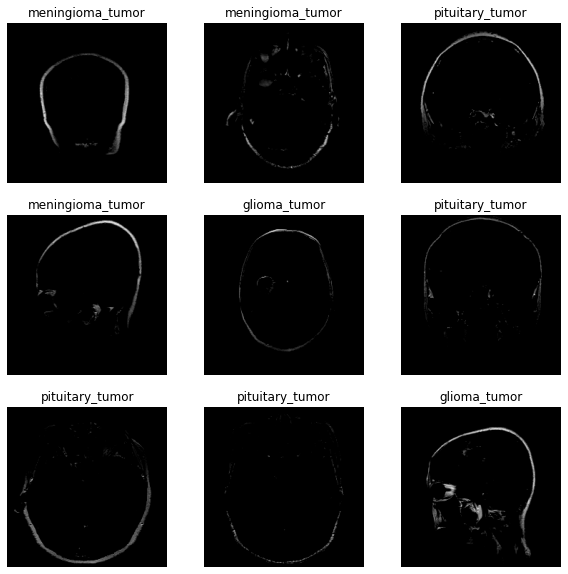

In [ ]:
train_ds_normalized = train_ds.map(lambda x, y: (my_tf_round(normalization_layer2(normalization_layer1(x)),4) , y))
image_batch, labels_batch = next(iter(train_ds_normalized))
first_image = image_batch[0]
print(np.min(first_image), np.max(first_image))
plt.figure(figsize=(10, 10))
for images, labels in train_ds_normalized.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy())
    plt.title(class_names[labels[i]])
    plt.axis("off")

-1.0 0.6102


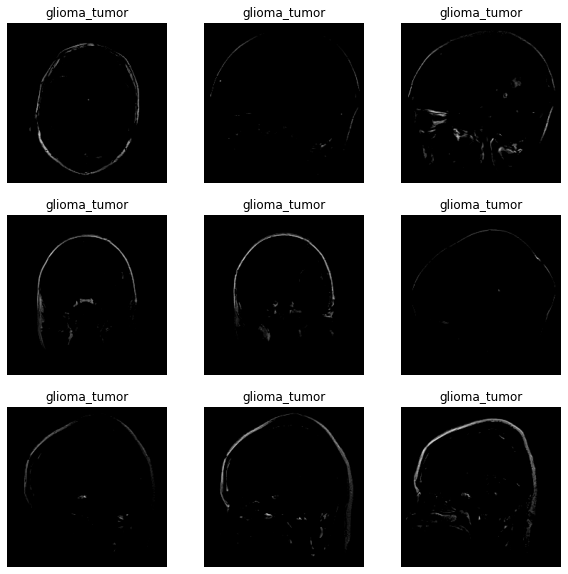

In [ ]:
val_ds_normalized = val_ds.map(lambda x, y: (my_tf_round(normalization_layer2(normalization_layer1(x)),4) , y))
image_batch, labels_batch = next(iter(val_ds_normalized))

print(np.min(first_image), np.max(first_image))
plt.figure(figsize=(10, 10))
for images, labels in val_ds_normalized.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy())
    plt.title(class_names[labels[i]])
    plt.axis("off")

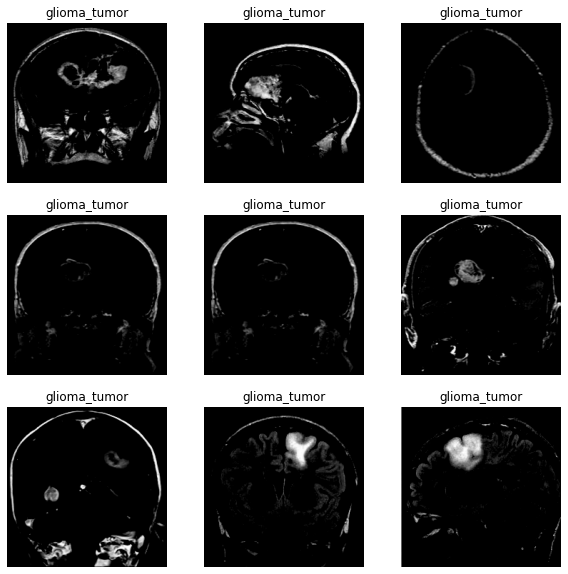

In [ ]:
test_ds_normalized = test_ds.map(lambda x, y: (my_tf_round(normalization_layer2(normalization_layer1(x)),4) , y))
image_batch, labels_batch = next(iter(test_ds_normalized))
plt.figure(figsize=(10, 10))
for images, labels in test_ds_normalized.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy())
    plt.title(class_names[labels[i]])
    plt.axis("off")

In [ ]:
y_test = [label for images, labels in test_ds_normalized for label in labels.numpy()]

In [ ]:
def display_report_and_matrix(y_pred, model):
    print(f'Test {model} Tensorflow and Keras')
   
    y_prediction = np.argmax(y_pred,axis=1)
    report = classification_report(y_test, y_prediction, target_names=class_names)
    print(f'{report}')

    fig, ax = plt.subplots(figsize=(10, 10)) 
    ax.set_title(f'Confusion Matrix {model} Tensorflow and Keras')
    cm = confusion_matrix(y_test,y_prediction)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=class_names)
    disp.plot(cmap='Blues', ax=ax)

In [ ]:
def display_plot(history, model):
    plt.figure(figsize=(14, 8))
    tab_plot = [{
                  "id": 1,
                  "variables":['accuracy', 'val_accuracy'],
                  "labels":['Training Accuracy', 'Validation Accuracy'],
                  "legend":'lower right',
                  "title":f'Accuracy Tensorflow and Keras - {model}',
                  "ylabel":'Accuracy'
              },{ 
                  "id": 2,
                  "variables":['loss', 'val_loss'],
                  "labels":['Training Loss', 'Validation Loss'],
                  "legend":'upper right',
                  "title":f'Loss Tensorflow and Keras - {model}',
                  "ylabel":'Loss'
              }]
    epochs_range = range(25)
    for tab in tab_plot: 
          plt.subplot(1, 2, tab['id'])
          plt.plot(epochs_range, history.history[tab['variables'][0]], label=tab['labels'][0], marker='o', markerfacecolor='green',color='green')
          plt.plot(epochs_range, history.history[tab['variables'][1]], label=tab['labels'][1], marker='o', markerfacecolor='blue',color='blue')
          plt.legend(loc=tab['legend'])
          plt.title(tab['title'])
          plt.xlabel('Epochs')
          plt.ylabel(tab['ylabel'])
    plt.show()

In [ ]:
from tensorflow.keras.applications import MobileNetV2 
mobilenet =  MobileNetV2(weights='imagenet',include_top=False,input_shape=(image_size,image_size,3),alpha=1)

9420800/9406464 [==============================] - 0s 0us/step


In [ ]:
model = mobilenet.output
model = tf.keras.layers.GlobalAveragePooling2D()(model)
model = tf.keras.layers.Dropout(rate=0.2)(model)
model = tf.keras.layers.Dense(4,activation='softmax')(model)
model = tf.keras.models.Model(inputs=mobilenet.input, outputs = model)

In [ ]:
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
              metrics=['accuracy'])

In [ ]:
print('Train Mobilenetv2 Tensorflow and Keras')
history_mobilenet_v2 = model.fit(train_ds_normalized,  validation_data=(val_ds_normalized), epochs=25)

Train Mobilenetv2 Tensorflow and Keras
Epoch 1/25
81/81 [==============================] - 38s 181ms/step - loss: 0.4261 - accuracy: 0.8517 - val_loss: 10.1817 - val_accuracy: 0.5226
Epoch 2/25
81/81 [==============================] - 15s 179ms/step - loss: 0.1848 - accuracy: 0.9353 - val_loss: 5.5552 - val_accuracy: 0.5714
Epoch 3/25
81/81 [==============================] - 15s 175ms/step - loss: 0.1447 - accuracy: 0.9559 - val_loss: 5.7154 - val_accuracy: 0.4808
Epoch 4/25
81/81 [==============================] - 14s 173ms/step - loss: 0.0920 - accuracy: 0.9714 - val_loss: 17.8391 - val_accuracy: 0.3136
Epoch 5/25
81/81 [==============================] - 14s 172ms/step - loss: 0.1035 - accuracy: 0.9655 - val_loss: 2.1679 - val_accuracy: 0.7735
Epoch 6/25
81/81 [==============================] - 15s 175ms/step - loss: 0.1012 - accuracy: 0.9655 - val_loss: 3.8853 - val_accuracy: 0.6620
Epoch 7/25
81/81 [==============================] - 14s 174ms/step - loss: 0.0723 - accuracy: 0.9748 

Test Mobilenetv2 Tensorflow and Keras
                  precision    recall  f1-score   support

    glioma_tumor       1.00      0.17      0.29       100
meningioma_tumor       0.69      0.57      0.62       115
        no_tumor       0.42      0.97      0.59       105
 pituitary_tumor       0.86      0.50      0.63        74

        accuracy                           0.56       394
       macro avg       0.74      0.55      0.53       394
    weighted avg       0.73      0.56      0.53       394



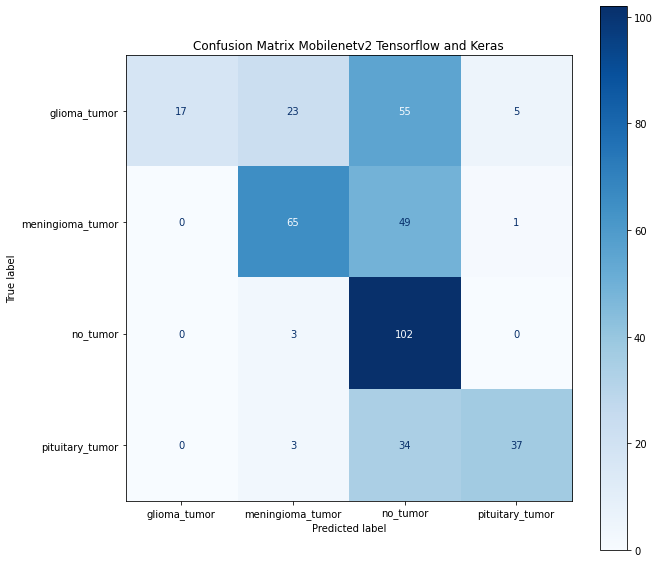

In [ ]:
y_pred_mobilenet_v2 = model.predict(test_ds_normalized)
display_report_and_matrix(y_pred_mobilenet_v2, 'Mobilenetv2')

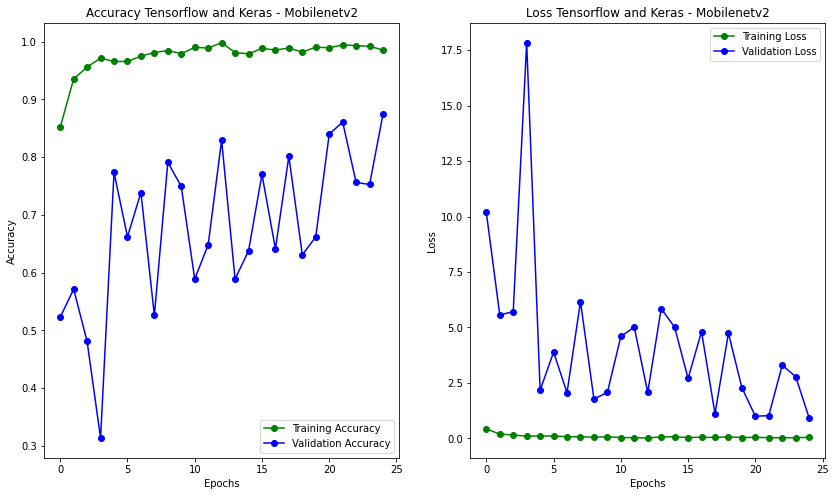

In [ ]:
display_plot(history_mobilenet_v2, 'Mobilenetv2')

In [ ]:
from tensorflow.keras.applications import DenseNet121
dense =  DenseNet121(weights='imagenet',include_top=False,input_shape=(image_size,image_size,3))

In [ ]:
model_densenet = dense.output
model_densenet = tf.keras.layers.GlobalAveragePooling2D()(model_densenet)
model_densenet = tf.keras.layers.Dense(4,activation='softmax')(model_densenet)
model_densenet = tf.keras.models.Model(inputs=dense.input, outputs = model_densenet)

In [ ]:
model_densenet.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
              metrics=['accuracy'])

In [ ]:
print('Train DenseNet121 Tensorflow and Keras')
history_densenet = model_densenet.fit(train_ds_normalized, validation_data=val_ds_normalized, epochs=25)

Train DenseNet121 Tensorflow and Keras
Epoch 1/25
81/81 [==============================] - 18s 219ms/step - loss: 0.2113 - accuracy: 0.9222 - val_loss: 1.0760 - val_accuracy: 0.6829
Epoch 2/25
81/81 [==============================] - 18s 218ms/step - loss: 0.1744 - accuracy: 0.9361 - val_loss: 0.5741 - val_accuracy: 0.8258
Epoch 3/25
81/81 [==============================] - 18s 211ms/step - loss: 0.1332 - accuracy: 0.9551 - val_loss: 4.5773 - val_accuracy: 0.4216
Epoch 4/25
81/81 [==============================] - 19s 226ms/step - loss: 0.0895 - accuracy: 0.9710 - val_loss: 1.0931 - val_accuracy: 0.7456
Epoch 5/25
81/81 [==============================] - 18s 214ms/step - loss: 0.1023 - accuracy: 0.9621 - val_loss: 4.5493 - val_accuracy: 0.2718
Epoch 6/25
81/81 [==============================] - 18s 214ms/step - loss: 0.0912 - accuracy: 0.9679 - val_loss: 0.7242 - val_accuracy: 0.7840
Epoch 7/25
81/81 [==============================] - 18s 223ms/step - loss: 0.0739 - accuracy: 0.9768 - 

Test DenseNet121 Tensorflow and Keras
                  precision    recall  f1-score   support

    glioma_tumor       0.93      0.28      0.43       100
meningioma_tumor       0.70      1.00      0.82       115
        no_tumor       0.71      1.00      0.83       105
 pituitary_tumor       0.98      0.70      0.82        74

        accuracy                           0.76       394
       macro avg       0.83      0.75      0.73       394
    weighted avg       0.82      0.76      0.73       394



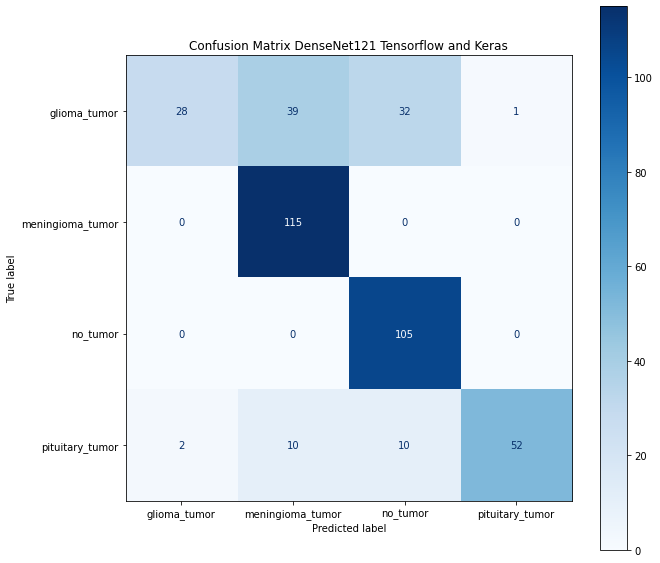

In [ ]:
y_pred_densenet = model_densenet.predict(test_ds_normalized)
display_report_and_matrix(y_pred_densenet, 'DenseNet121')

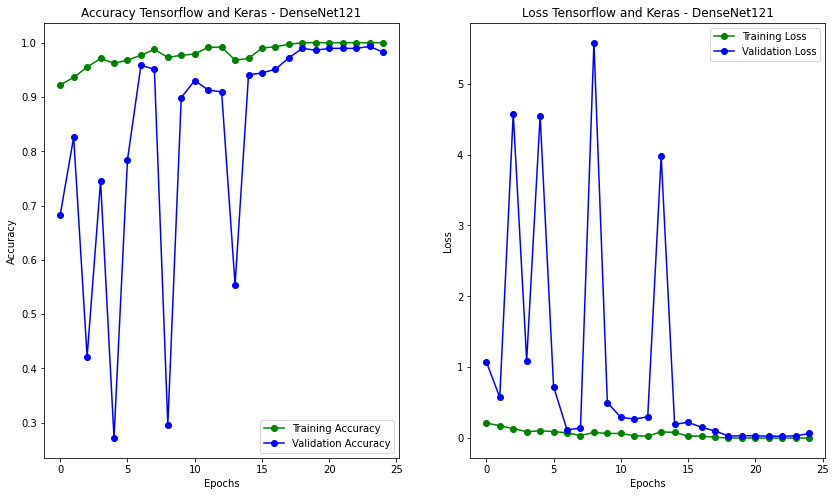

In [ ]:
display_plot(history_densenet, 'DenseNet121')

In [ ]:
from tensorflow.keras.applications import ResNet50
resnet =  ResNet50(weights='imagenet',include_top=False,input_shape=(image_size,image_size,3))

In [ ]:
model_resnet50 = resnet.output
model_resnet50 = tf.keras.layers.GlobalAveragePooling2D()(model_resnet50)
model_resnet50 = tf.keras.layers.Dense(4,activation='softmax')(model_resnet50)
model_resnet50 = tf.keras.models.Model(inputs=resnet.input, outputs = model_resnet50)

In [ ]:
model_resnet50.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
              metrics=['accuracy'])

In [ ]:
print('Train Resnet50 Tensorflow and Keras')
history_resnet50 = model_resnet50.fit(train_ds_normalized, validation_data=val_ds_normalized, epochs=25)

Train Resnet50 Tensorflow and Keras
Epoch 1/25
81/81 [==============================] - 21s 196ms/step - loss: 0.6460 - accuracy: 0.7967 - val_loss: 22.9876 - val_accuracy: 0.2857
Epoch 2/25
81/81 [==============================] - 15s 186ms/step - loss: 0.2622 - accuracy: 0.9048 - val_loss: 1.8031 - val_accuracy: 0.2892
Epoch 3/25
81/81 [==============================] - 16s 190ms/step - loss: 0.1759 - accuracy: 0.9419 - val_loss: 8.0147 - val_accuracy: 0.2892
Epoch 4/25
81/81 [==============================] - 16s 189ms/step - loss: 0.0886 - accuracy: 0.9710 - val_loss: 2.2732 - val_accuracy: 0.1394
Epoch 5/25
81/81 [==============================] - 16s 186ms/step - loss: 0.0790 - accuracy: 0.9764 - val_loss: 1.8520 - val_accuracy: 0.2997
Epoch 6/25
81/81 [==============================] - 15s 186ms/step - loss: 0.0717 - accuracy: 0.9775 - val_loss: 4.7478 - val_accuracy: 0.2962
Epoch 7/25
81/81 [==============================] - 15s 186ms/step - loss: 0.0515 - accuracy: 0.9853 - va

Test ResNet50 Tensorflow and Keras
                  precision    recall  f1-score   support

    glioma_tumor       0.96      0.26      0.41       100
meningioma_tumor       0.86      0.97      0.91       115
        no_tumor       0.66      1.00      0.80       105
 pituitary_tumor       0.90      0.95      0.92        74

        accuracy                           0.79       394
       macro avg       0.85      0.79      0.76       394
    weighted avg       0.84      0.79      0.76       394



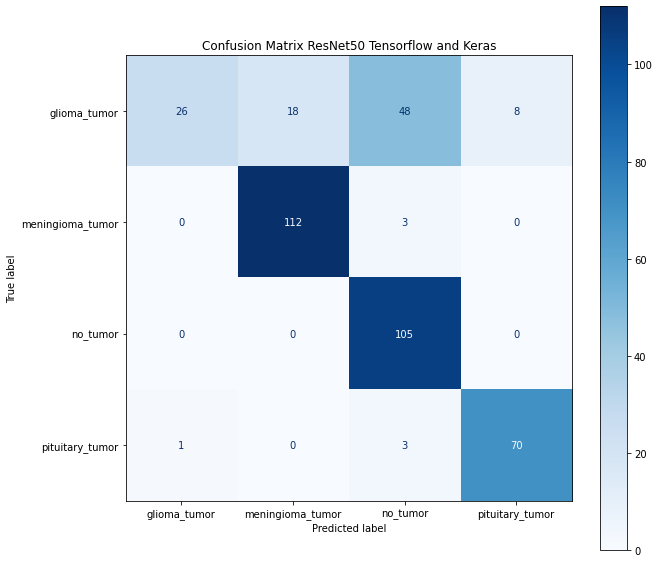

In [ ]:
y_pred_resnet50 = model_resnet50.predict(test_ds_normalized)
display_report_and_matrix(y_pred_resnet50, 'ResNet50')

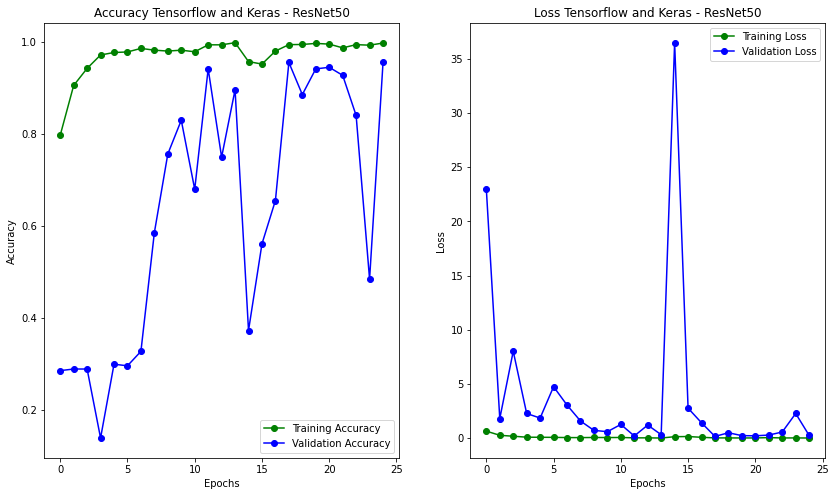

In [ ]:
display_plot(history_resnet50, 'ResNet50')